# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [4]:
import tensorflow as tf
from scipy.io import loadmat

In [5]:
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [6]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [7]:
# Building X_train, X_test, y_train, y_test
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

In [8]:
# Printing shape of X_train, X_test
print(X_train.shape)
print(X_test.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [9]:
# Moving the axis of X_train and X_train
# from (32, 32, 3, 73257) to (73257, 32, 32, 3)
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1 , 0)

In [10]:
# Printing shape of the axis
print(X_train.shape) 
print(X_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


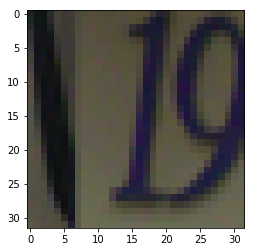

[1]


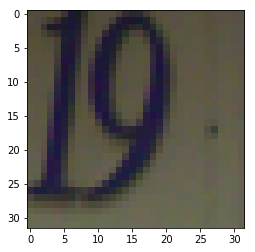

[9]


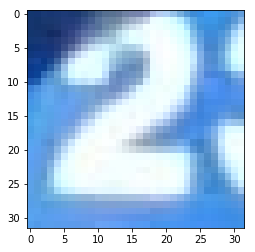

[2]


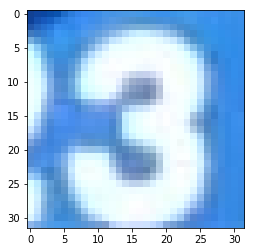

[3]


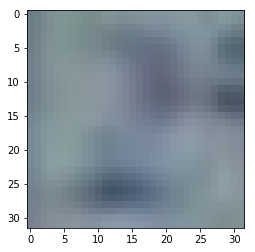

[2]


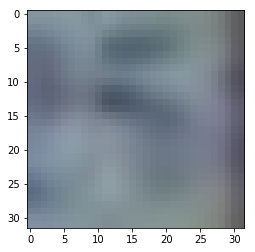

[5]


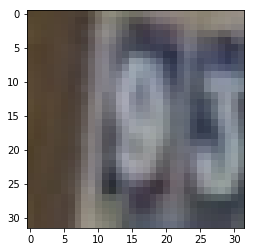

[9]


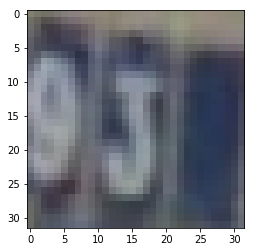

[3]


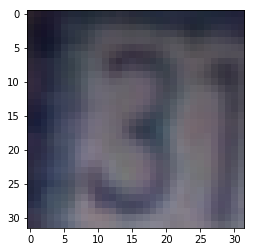

[3]


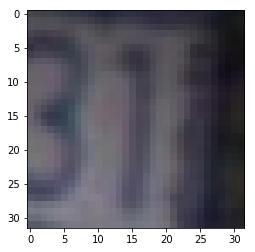

[1]


In [11]:
# Plotting the random sample of images
for i in range(10):
    plt.imshow(X_train[i, :, :, :,])
    plt.show()
    print(y_train[i])

In [12]:
# Grayscaling the images
X_train_gs = np.mean(X_train, 3).reshape(73257, 32, 32, 1)/255
X_test_gs = np.mean(X_test,3).reshape(26032, 32,32 ,1)/255
X_train_for_plotting = np.mean(X_train,3)

In [13]:
# Printing the shape
print(X_train_gs.shape)

(73257, 32, 32, 1)


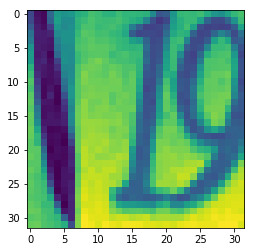

[1]


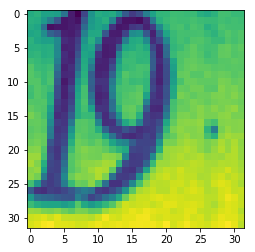

[9]


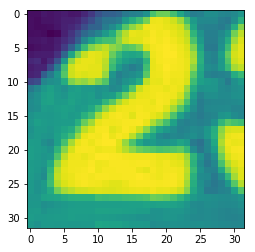

[2]


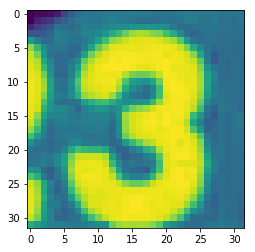

[3]


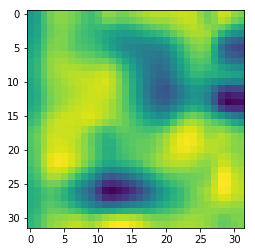

[2]


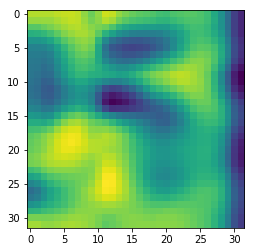

[5]


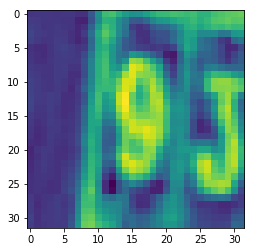

[9]


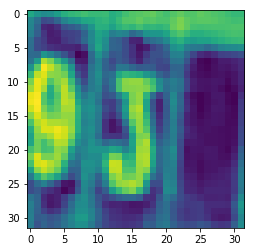

[3]


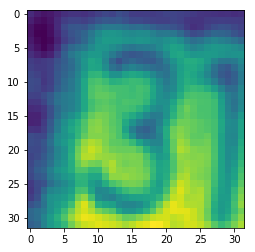

[3]


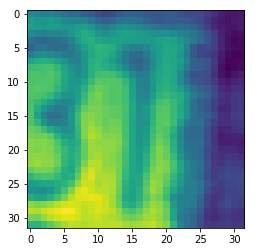

[1]


In [14]:
# Printing random sample from grayscaling images
for i in range(10):
    plt.imshow(X_train_for_plotting[i, :, :,])
    plt.show()
    print(y_train[i])

In [15]:
# Printing the shape
print(X_train[0].shape)

(32, 32, 3)


In [16]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(y_train)
y_train_oh = enc.transform(y_train).toarray()
y_test_oh = enc.transform(y_test).toarray()

In [17]:
y_test_oh[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

[5]


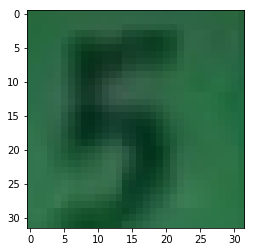

In [18]:
plt.imshow(X_test[0])
print(y_test[0])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
# Building Checkpoint and Early stopping callbacks
def get_checkpoint_mlp():
    checkpoint = ModelCheckpoint(filepath = 'Seq_Mode', save_best_only=True, 
                             save_weights_only=True, monitor='val_loss', verbose=1)
    return checkpoint
def get_earlystop_mlp():
    earlystop = EarlyStopping(patience=5, monitor='loss')
    return earlystop

In [21]:
# Building the MLP model 
def get_model_mlp():
    model = Sequential([
        Flatten(input_shape=X_train[0].shape),
        Dense(128*4, activation='relu',input_shape=X_train[0].shape),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])
    # Compiling the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

In [22]:
model_mlp = get_model_mlp()

# Summarize the model
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [23]:
checkpoint_mlp = get_checkpoint_mlp()
earlystop_mlp = get_earlystop_mlp()

In [22]:
# Training the model
history = model_mlp.fit(X_train, y_train_oh, callbacks=[checkpoint_mlp, earlystop_mlp], 
                        batch_size=128, validation_data=(X_test, y_test_oh), epochs=30)

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73216/73257 [============================>.] - ETA: 0s - loss: 1.9736 - acc: 0.2989
Epoch 00001: val_loss improved from inf to 2.20830, saving model to Seq_Mode\my_Seq_Model
73257/73257 [==============================] - 67s 911us/sample - loss: 1.9734 - acc: 0.2989 - val_loss: 2.2083 - val_acc: 0.2893
Epoch 2/30
73216/73257 [============================>.] - ETA: 0s - loss: 1.6023 - acc: 0.4471- E
Epoch 00002: val_loss improved from 2.20830 to 1.94024, saving model to Seq_Mode\my_Seq_Model
73257/73257 [==============================] - 64s 868us/sample - loss: 1.6023 - acc: 0.4472 - val_loss: 1.9402 - val_acc: 0.4245
Epoch 3/30
73216/73257 [============================>.] - ETA: 0s - loss: 1.4712 - acc: 0.5102
Epoch 00003: val_loss improved from 1.94024 to 1.51389, saving model to Seq_Mode\my_Seq_Model
73257/73257 [==============================] - 64s 871us/sample - loss: 1.4712 - acc: 0.5102 - val_loss: 1.5139 - val_acc: 0

In [23]:
#checking Directroy
!dir

Capstone\ Project.ipynb		data
checkpoint			Seq_Mode\\my_Seq_Model.data-00000-of-00001
CNNweights.data-00000-of-00001	Seq_Mode\\my_Seq_Model.index
CNNweights.index


Text(0.5, 1.0, 'Loss')

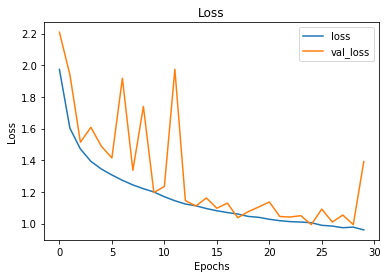

In [24]:
# Plotting Epochs vs. Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

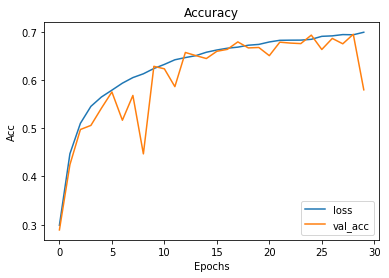

In [25]:
# Plotting Epochs vs. Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['loss','val_acc'], loc='lower right')
plt.title("Accuracy")

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [24]:
# Building CNN model
def get_model_cnn():
    model= Sequential([
        Conv2D(filters= 16, kernel_size= 3, activation='relu', padding='SAME', input_shape=X_train[0].shape),
        BatchNormalization(),
        Conv2D(filters= 16, kernel_size = 3, padding='SAME', activation='relu'),
        MaxPool2D(pool_size = (2,2)),
        Conv2D(filters= 32, kernel_size = 3, padding='SAME', activation='relu'),
        BatchNormalization(),
        Conv2D(filters= 32, kernel_size = 3, padding='SAME', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters= 64, kernel_size = 3, padding='SAME', activation='relu'),
        BatchNormalization(),
        Conv2D(filters= 64, kernel_size = 3, padding='SAME', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        tf.keras.layers.Dropout(0.3),
        Dense(1024, activation='relu'),
        #tf.keras.layers.Dropout(0.3),
        #Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    # Compiling the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model
    

In [25]:
model_cnn = get_model_cnn()

In [26]:
# Model Summary
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)       

In [27]:
# Callbacks for checkpoint and Earlystopping
def get_checkpoint_cnn():
    checkpoint = ModelCheckpoint(filepath='CNNweights', save_best_only=True, save_weights_only=True, monitor='val_acc')
    return checkpoint
def get_earlystop_cnn():
    earlystop = EarlyStopping(monitor='loss',patience=2, verbose=1)
    return earlystop

In [28]:
checkpoint_cnn = get_checkpoint_cnn()
earlystop_cnn = get_earlystop_cnn()

In [29]:
# Checking shape of X_train
X_train.shape

(73257, 32, 32, 3)

In [33]:
# Training the model
history = model_cnn.fit(X_train, y_train_oh, callbacks=[checkpoint_cnn, earlystop_cnn], 
                     batch_size=512, validation_split=0.20, epochs=10)

Train on 58605 samples, validate on 14652 samples
Epoch 1/10
58605/58605 [==============================] - 783s 13ms/sample - loss: 0.3091 - acc: 0.9078 - val_loss: 0.2998 - val_acc: 0.9106
Epoch 2/10
58605/58605 [==============================] - 776s 13ms/sample - loss: 0.2781 - acc: 0.9173 - val_loss: 0.2793 - val_acc: 0.9175
Epoch 3/10
58605/58605 [==============================] - 787s 13ms/sample - loss: 0.2563 - acc: 0.9246 - val_loss: 0.2744 - val_acc: 0.9180
Epoch 4/10
58605/58605 [==============================] - 763s 13ms/sample - loss: 0.2340 - acc: 0.9304 - val_loss: 0.2724 - val_acc: 0.9180
Epoch 5/10
58605/58605 [==============================] - 756s 13ms/sample - loss: 0.2209 - acc: 0.9350 - val_loss: 0.2651 - val_acc: 0.9249
Epoch 6/10
58605/58605 [==============================] - 743s 13ms/sample - loss: 0.2047 - acc: 0.9395 - val_loss: 0.2671 - val_acc: 0.9233
Epoch 7/10
58605/58605 [==============================] - 738s 13ms/sample - loss: 0.1921 - acc: 0.9426 

In [34]:
!dir

Capstone\ Project.ipynb		data
checkpoint			Seq_Mode\\my_Seq_Model.data-00000-of-00001
CNNweights.data-00000-of-00001	Seq_Mode\\my_Seq_Model.index
CNNweights.index


Text(0.5, 1.0, 'Loss')

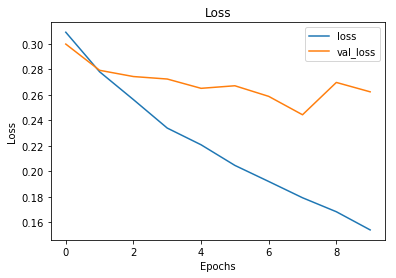

In [35]:
# Plotting Epochs vs. Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

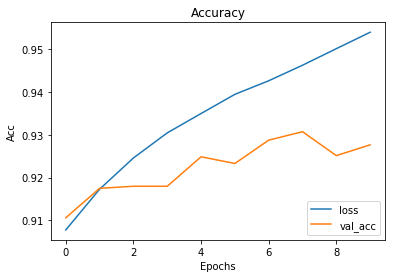

In [36]:
# Plotting Epochs vs. Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['loss','val_acc'], loc='lower right')
plt.title("Accuracy")

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [36]:
# MLP model best weights
model_mlp = get_model_mlp()
model_mlp.load_weights('Seq_Mode')

In [39]:
# CNN model best weights
model_cnn = get_model_cnn()
model_cnn.load_weights('CNNweights')

In [ ]:
import random

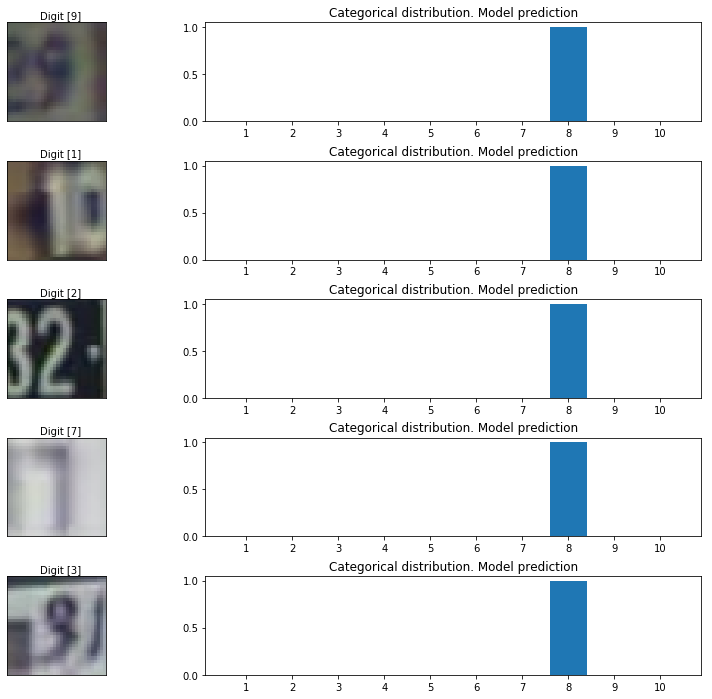

In [42]:
# Predictions for MLP model
num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model_mlp.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

In [ ]:
# Predictions for MLP model

num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model_cnn.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()